In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
df=pd.read_csv("/kaggle/input/dslatam/dataset_SCL.csv") #load dataset
df.head() #show first 5 rows at table

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [2]:
df.shape

(68206, 18)

In [3]:
df.dtypes # show type of variables for every column

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

In [4]:
# Adjust variables for correct format
df['Fecha-I']=pd.to_datetime(df['Fecha-I'])
df['Fecha-O']=pd.to_datetime(df['Fecha-O']) 

#Check if object variable can be category
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col} has {df[col].nunique()} different values")
    elif df[col].dtype == 'int64':
        print(f"{col} is int64 and max value is: {df[col].max()} and min value is: {df[col].min()}")
        

Vlo-I has 750 different values
Ori-I has 1 different values
Des-I has 64 different values
Emp-I has 30 different values
Vlo-O has 866 different values
Ori-O has 1 different values
Des-O has 63 different values
Emp-O has 32 different values
DIA is int64 and max value is: 31 and min value is: 1
MES is int64 and max value is: 12 and min value is: 1
AÑO is int64 and max value is: 2018 and min value is: 2017
DIANOM has 7 different values
TIPOVUELO has 2 different values
OPERA has 23 different values
SIGLAORI has 1 different values
SIGLADES has 62 different values


In [5]:
#Based on the data catalog and the information above we have a cut-off for categorical variables with less than 500 values 
#I am doing this because I believe that this is just a sample of a bigger dataset which can contain more destination and origin cities.
catcols=[]
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique()<200:
        df[col]=df[col].astype('category')
        catcols.append(col)
    elif df[col].dtype == 'int64' and df[col].max() < 127:
        df[col]=df[col].astype('int8')
    elif df[col].dtype == 'int64' and df[col].max() < 32767: 
        df[col]=df[col].astype('int16')
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I              category
Des-I              category
Emp-I              category
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O              category
Des-O              category
Emp-O              category
DIA                    int8
MES                    int8
AÑO                   int16
DIANOM             category
TIPOVUELO          category
OPERA              category
SIGLAORI           category
SIGLADES           category
dtype: object

In [6]:
#Considering that this is just a sample and assuming that the original dataset is a CSV file, the right thing to do is to add an argument on the read_csv function, dtypes={dict of every column with the value as the dtype}
#We could

In [7]:
%%time
#creating a function and dummy variables for month and day is a simple way to create the high_season feat
def high_season(x):
    month=x.month
    day=x.day
    if ((month == 12 and day >= 15) or
     (month in [1,2]) or 
     (month == 3 and day <= 3) or 
     (month == 7 and day >= 15 and day <= 31) or 
     (month == 9 and day >= 11 and day <= 30)): return True #the outer parentesis is to multiple line conditions
    else:
        return False
    
df['high_season']=df['Fecha-I'].apply(lambda x: high_season(x))
df.groupby([df['Fecha-I'].dt.month,'high_season'])['Fecha-O'].count().unstack()

     

CPU times: user 389 ms, sys: 9.64 ms, total: 398 ms
Wall time: 401 ms


high_season,False,True
Fecha-I,,
1,NaN,6108.0
2,NaN,5561.0
3,4903.0,577.0
4,5021.0,NaN
5,5239.0,NaN
6,4982.0,NaN
7,2701.0,3290.0
8,5744.0,NaN
9,1853.0,3757.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


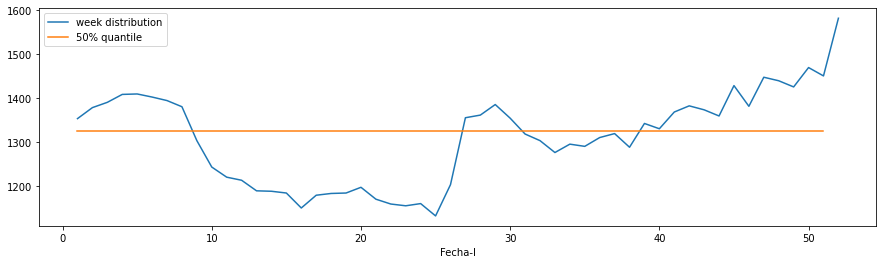

Weeks that should be the high_season (based on number of flights) 
[ 1  2  3  4  5  6  7  8 27 28 29 30 39 40 41 42 43 44 45 46 47 48 49 50
 51 52]

 instead of [ 1  2  3  4  5  6  7  8  9 28 29 30 31 37 38 39 50 51 52]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


high_season_2,False,True
high_season,,
False,28073,17371
True,3764,18998


In [8]:
week_dist=df[df['Fecha-I'].dt.year==2017].groupby(df['Fecha-I'].dt.week)['Fecha-O'].count()
week_dist.plot(figsize=(15,4)) #not using year because only has dates in 2017
q=week_dist.quantile(q=0.5)
plt.plot([1,51],[q,q])
plt.legend(['week distribution','50% quantile'])
plt.show()
#the graph below show us the quantity of flights by week in 2017, we can see that the high season variable 
print(f"""Weeks that should be the high_season (based on number of flights) \n{week_dist[week_dist>q].index.values}
\n instead of {df[df['high_season']==1]['Fecha-I'].dt.week.value_counts().index.sort_values().values}""")
df['high_season_2']=(df['Fecha-I'].dt.week.isin(week_dist[week_dist>q].index.values)).astype(bool)
# parallel high_season for this analysis
df.groupby(['high_season','high_season_2'])['Fecha-I'].count().unstack()

In [9]:
df['min_diff']=((df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60).astype("int16") #diff between dates in minutes
df['delay_15']=(df['min_diff']>15).astype(bool) #bool is lighter than intergers, using vectorization we can speed-up this step
df['period_day']=df['Fecha-I'].dt.hour.apply(lambda x: 'night' if x >= 19 or x<= 4 else (
                                            'morning' if x <= 12 else 'afternoon' )).astype('category') # one alternative method: map()
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,high_season_2,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,True,True,3,False,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,True,True,9,False,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,True,True,9,False,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,True,True,3,False,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,True,True,-2,False,night


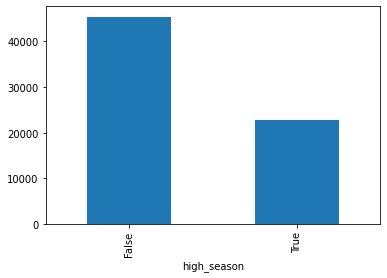

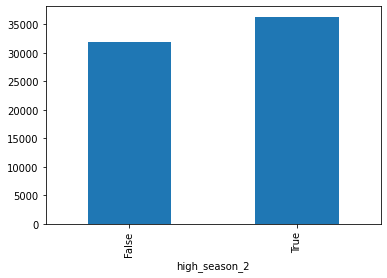

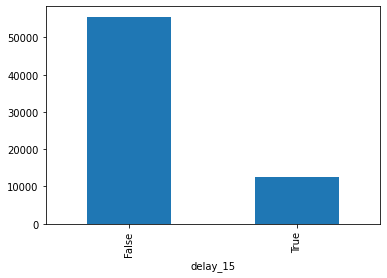

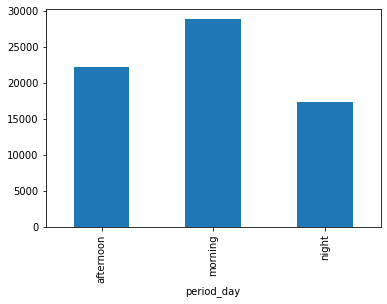

In [10]:
for var in ['high_season','high_season_2','delay_15','period_day']:
    df.groupby(var)['Fecha-I'].count().plot.bar()
    plt.show()
#We can see that the generated variables makes sense, in the next cell we are going to compare all of the variables with delay_15 to see if we can see a clear pattern in variables.

In [11]:
df[['high_season','min_diff','delay_15','period_day']].to_csv('d synthetic_features.csv')
#The pdf is not clear if the file should contain all the variables in the dataframe,as writen I only exported the created features


In [12]:
(df.groupby([var,'delay_15'])['Fecha-I'].count()/df.groupby([var])['Fecha-I'].count()).unstack().sort_values(by=[True])

delay_15,False,True
period_day,,
morning,0.838027,0.161973
night,0.799977,0.200023
afternoon,0.797004,0.202996


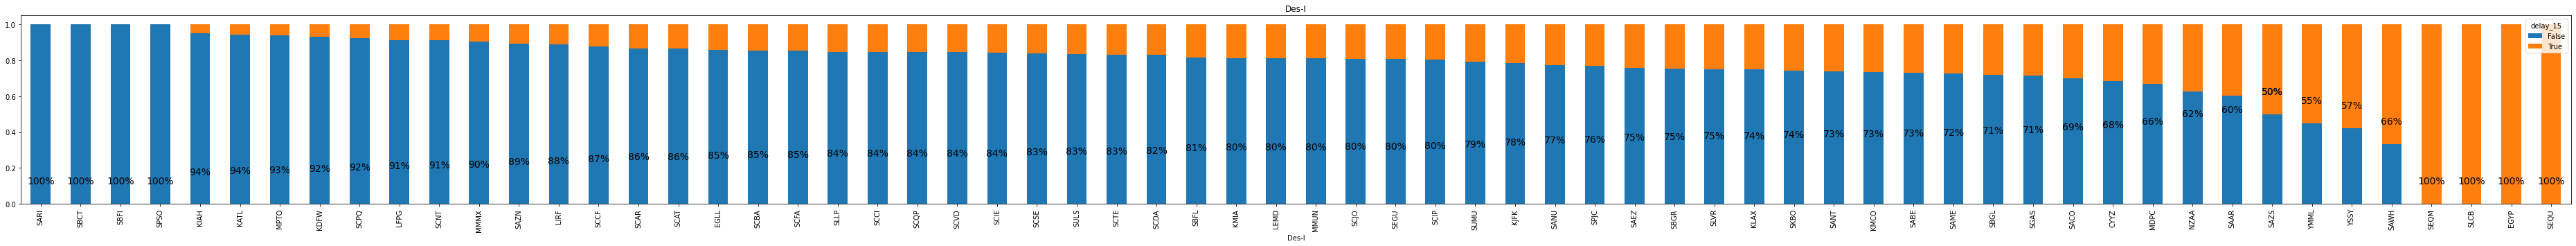

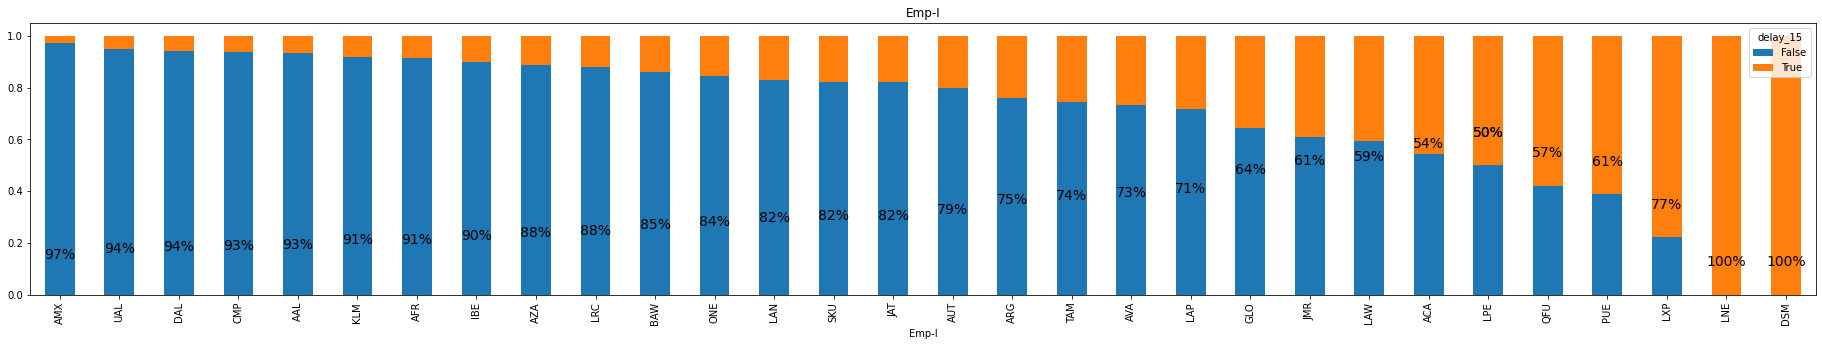

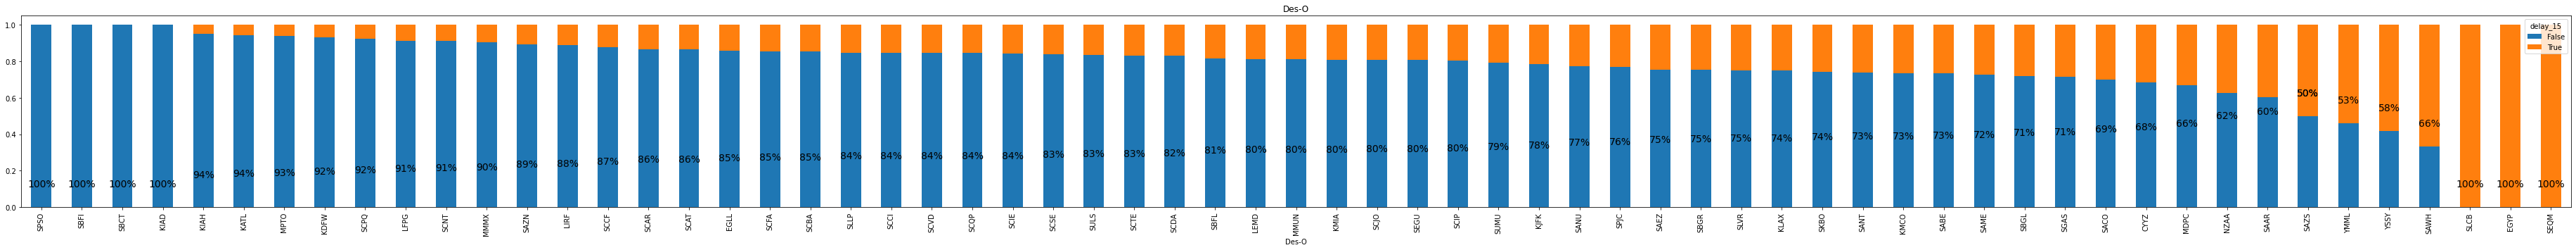

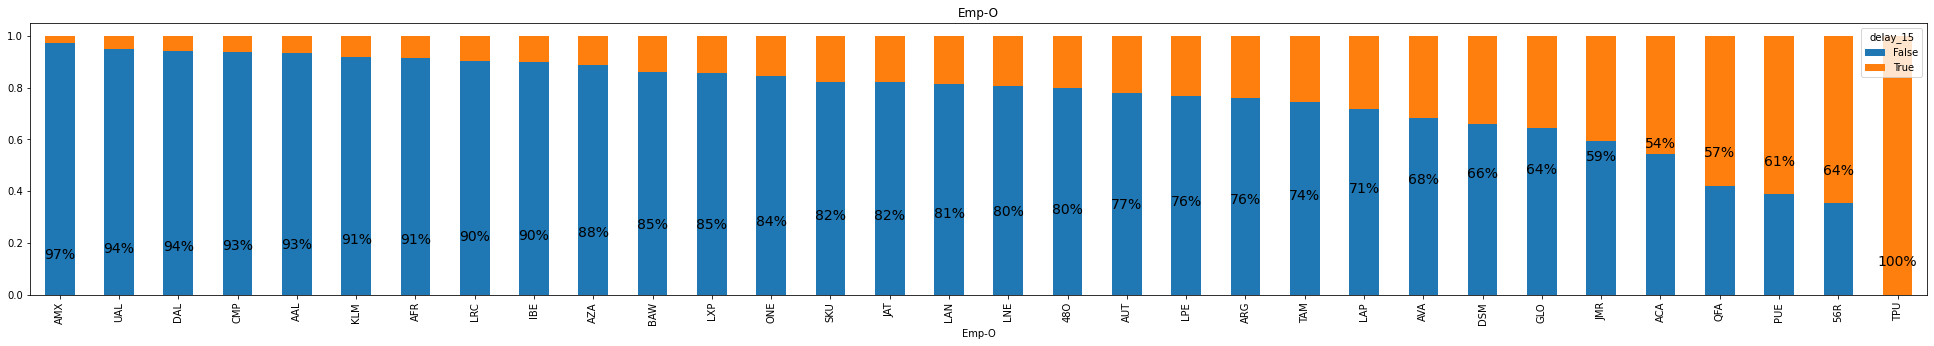

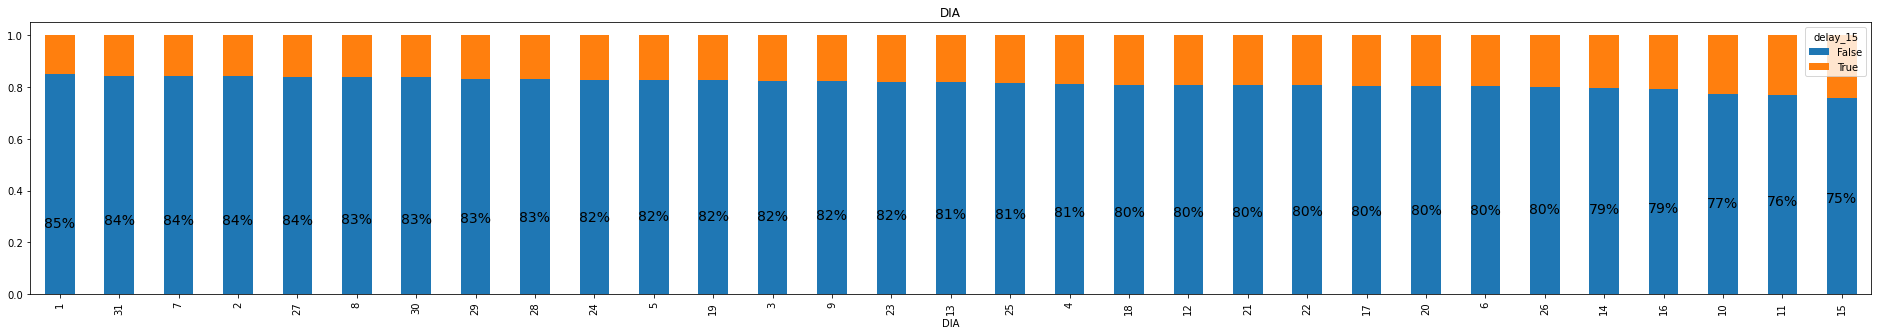

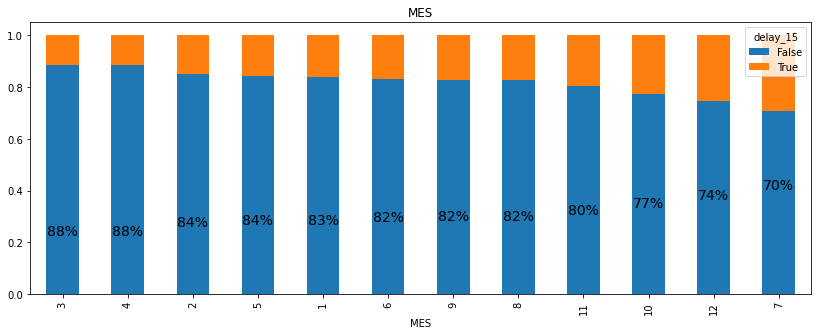

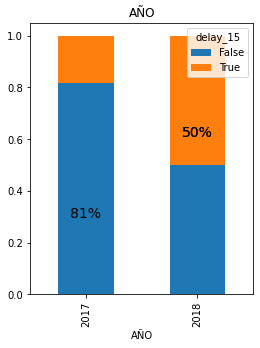

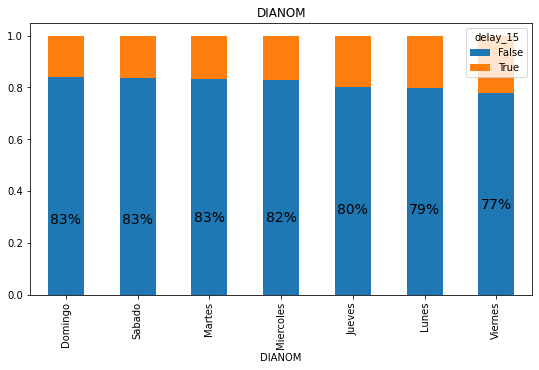

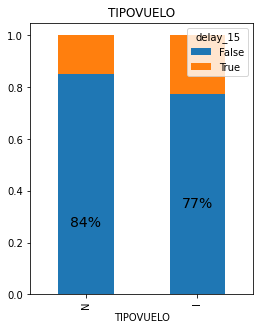

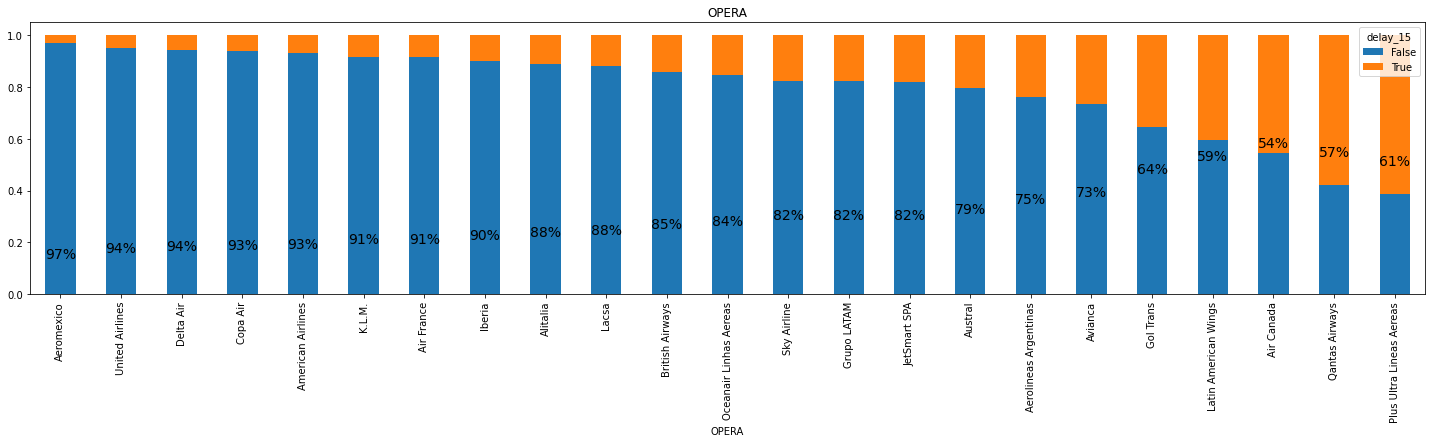

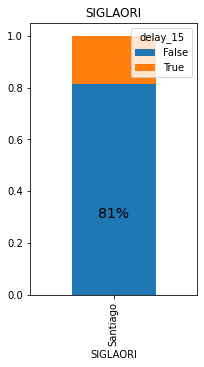

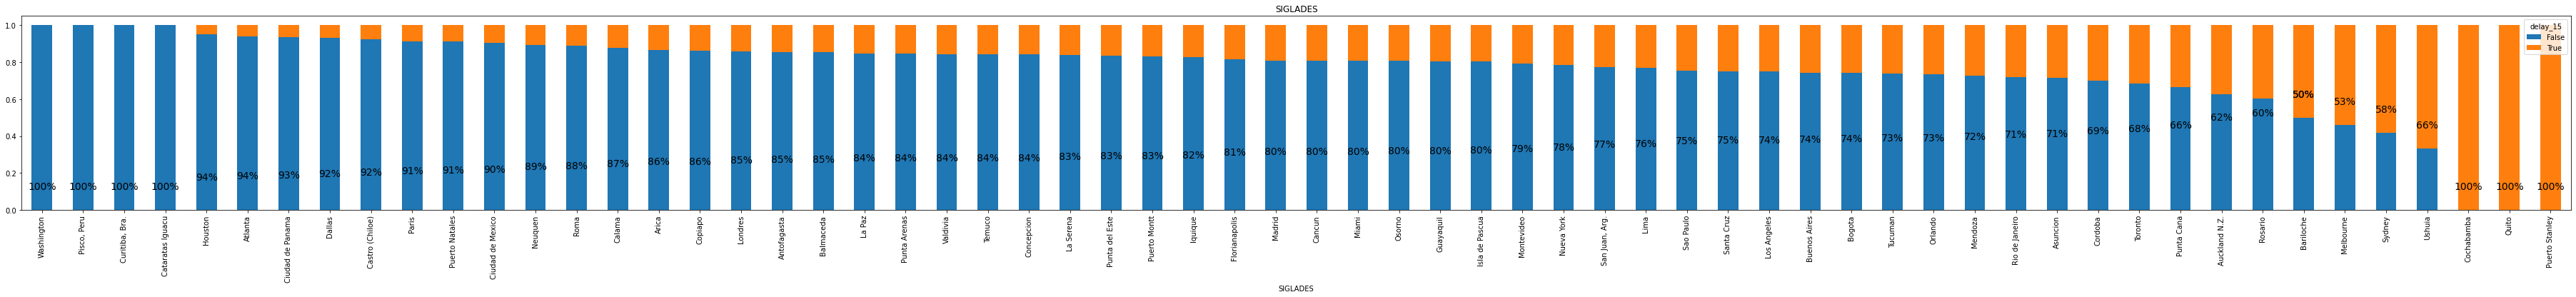

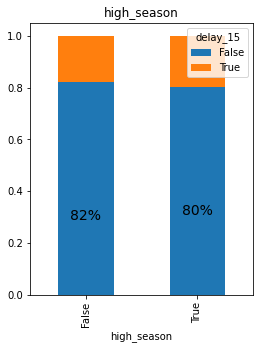

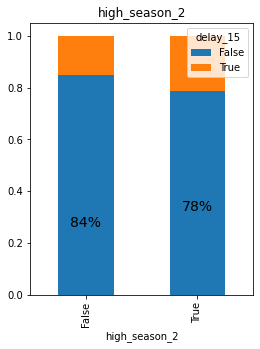

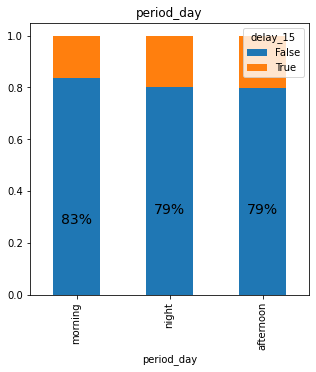

In [13]:
#First challenge - how is the data distributed?

for var in df.columns:
    if var not in ['Fecha-I','Fecha-O','Vlo-I','Vlo-O','Ori-O','Ori-I','delay_15','min_diff']:
        dif_clases=df[var].nunique()
        ax=(df.groupby([var,'delay_15'])['Fecha-I'].count()/df.groupby([var])['Fecha-I'].count()).unstack().sort_values(by=True).plot.bar(stacked=True,figsize=((int((dif_clases+4/2)),5)))
        for p in ax.patches:
            height = p.get_height()
            if np.isnan(height):
                height = 0
            if height <= 0.5:
                ax.text(p.get_x() + p.get_width()/2., height+0.1, f'{int((1-height)*100)}%', 
                    fontsize=14, color='black', ha='center', va='bottom')
        plt.title(var)
        plt.show()

In [14]:
# Considerations for alone distribution of variables 

#Some drivers to the study

# There is correlation expected between airlines and cities 
# see correlation between Emp-O and OPERA (can I group these and see make a flag if they are the same?)
# we have small peaks of delay on the days:  10,11,15 (?) maybe because of sallary? see correlation between day/month
# new high season makes more sense
# flights in the morning has less chance of delay or is it the companies that have more flights in the morning that has less delay?


In [15]:
df.sort_values(by=['Fecha-I'],inplace=True)
df.set_index('Fecha-I',inplace=True)

In [16]:
#check if previous flights can impact the actual flight
#the features of delay_last and perc_delay is only fair if we are predicting on the moment of flight
#the qtd_flights can be calculated before and is fair to use on the model
df['delay_previous_flight']=df['delay_15'].shift(1).astype(bool)
for h in [1,2,4,6,12,18,24]:
    df[f'delay_last_{h}h']=df['delay_15'].shift(1).rolling(f'{h}h').sum()
    df[f'qtd_flights_{h}h']=df['delay_15'].shift(1).rolling(f'{h}h').count()
    df[f'perc_delay_{h}h']=df['delay_15'].shift(1).rolling(f'{h}h').sum()/df['delay_15'].shift(1).rolling(f'{h}h').count()

In [17]:
df['delay_15'].value_counts(normalize=True)

False    0.81506
True     0.18494
Name: delay_15, dtype: float64

In [18]:
df.groupby(['delay_15','delay_previous_flight'])['Fecha-O'].count().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack()
#We have 18.49% delayed flights and 25.5% of those delayed flights had a flight with delay before
#but on the other hand, 16.89% of flights with delay before did not have delay

delay_previous_flight,False,True
delay_15,,
False,83.107282,16.892718
True,74.441097,25.558903


In [19]:
#what if we use high delay airline companies before the flight?

#what are the top airline companies that have most percentage of delay?
top_delay_companies_perc=df.groupby(['OPERA','delay_15'])['Fecha-O'].count().groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack().sort_values(by=True,ascending=[False])
comp_delay_5=list(top_delay_companies_perc.head(5).index.values)
comp_delay_10=list(top_delay_companies_perc.head(10).index.values)
print(comp_delay_5,comp_delay_10)
top_delay_companies_perc

['Plus Ultra Lineas Aereas', 'Qantas Airways', 'Air Canada', 'Latin American Wings', 'Gol Trans'] ['Plus Ultra Lineas Aereas', 'Qantas Airways', 'Air Canada', 'Latin American Wings', 'Gol Trans', 'Avianca', 'Aerolineas Argentinas', 'Austral', 'JetSmart SPA', 'Grupo LATAM']


delay_15,False,True
OPERA,,
Plus Ultra Lineas Aereas,38.775510,61.224490
Qantas Airways,42.051282,57.948718
Air Canada,54.336283,45.663717
Latin American Wings,59.318996,40.681004
Gol Trans,64.392060,35.607940
Avianca,73.437500,26.562500
Aerolineas Argentinas,75.987686,24.012314
Austral,79.729730,20.270270
JetSmart SPA,82.100457,17.899543


In [20]:
df[df['OPERA'].isin(comp_delay_5)]['delay_15'].shift(1).rolling('1h').sum()

Fecha-I
2017-01-01 02:05:00    NaN
2017-01-01 06:10:00    0.0
2017-01-01 11:00:00    0.0
2017-01-01 13:35:00    0.0
2017-01-01 13:35:00    1.0
                      ... 
2017-12-31 15:00:00    1.0
2017-12-31 16:30:00    0.0
2017-12-31 17:30:00    0.0
2017-12-31 21:10:00    0.0
2017-12-31 22:00:00    1.0
Name: delay_15, Length: 3289, dtype: float64

In [21]:
df['is_top_5_airlines_delay']=(df['OPERA'].isin(comp_delay_5)).astype(bool)
df['is_top_10_airlines_delay']=(df['OPERA'].isin(comp_delay_10)).astype(bool)
df['is_top_5_airlines_delay_and_delay_15']=((df['OPERA'].isin(comp_delay_5))&(df['delay_15'])).astype(bool)
df['is_top_10_airlines_delay_and_delay_15']=((df['OPERA'].isin(comp_delay_10))&(df['delay_15'])).astype(bool)

In [22]:
for h in [1,2,4,6,12,18,24]:
    for var in ['is_top_5_airlines_delay','is_top_10_airlines_delay',
               'is_top_5_airlines_delay_and_delay_15','is_top_10_airlines_delay_and_delay_15']:
        df[f'qtd_flights_{var}_{h}h']=df[var].shift(1).rolling(f'{h}h').sum()

In [23]:
features_no_cat_col=[feat for feat in df.columns if df[feat].dtype not in ["object","category"] and 
          feat not in ['delay_15','min_diff','Fecha-O','is_top_5_airlines_delay_and_delay_15',
                      'is_top_10_airlines_delay_and_delay_15']]
# delay_15/min_diff and the is_top_5/is_top_10 with delay_15 are correlated with delay_15 and must be excluded of features
features_no_cat_col

['DIA',
 'MES',
 'AÑO',
 'high_season',
 'high_season_2',
 'delay_previous_flight',
 'delay_last_1h',
 'qtd_flights_1h',
 'perc_delay_1h',
 'delay_last_2h',
 'qtd_flights_2h',
 'perc_delay_2h',
 'delay_last_4h',
 'qtd_flights_4h',
 'perc_delay_4h',
 'delay_last_6h',
 'qtd_flights_6h',
 'perc_delay_6h',
 'delay_last_12h',
 'qtd_flights_12h',
 'perc_delay_12h',
 'delay_last_18h',
 'qtd_flights_18h',
 'perc_delay_18h',
 'delay_last_24h',
 'qtd_flights_24h',
 'perc_delay_24h',
 'is_top_5_airlines_delay',
 'is_top_10_airlines_delay',
 'qtd_flights_is_top_5_airlines_delay_1h',
 'qtd_flights_is_top_10_airlines_delay_1h',
 'qtd_flights_is_top_5_airlines_delay_and_delay_15_1h',
 'qtd_flights_is_top_10_airlines_delay_and_delay_15_1h',
 'qtd_flights_is_top_5_airlines_delay_2h',
 'qtd_flights_is_top_10_airlines_delay_2h',
 'qtd_flights_is_top_5_airlines_delay_and_delay_15_2h',
 'qtd_flights_is_top_10_airlines_delay_and_delay_15_2h',
 'qtd_flights_is_top_5_airlines_delay_4h',
 'qtd_flights_is_top_1

In [24]:
df2=df[df.index>=pd.to_datetime('2017-01-02')]

In [25]:
df[df.index.date==pd.to_datetime('2017-03-05')][['OPERA','is_top_10_airlines_delay_and_delay_15','delay_15']].head(20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  """Entry point for launching an IPython kernel.


,OPERA,is_top_10_airlines_delay_and_delay_15,delay_15
Fecha-I,,,
2017-03-05 00:35:00,Grupo LATAM,True,True
2017-03-05 01:15:00,Latin American Wings,True,True
2017-03-05 01:32:00,Copa Air,False,False
2017-03-05 01:33:00,Avianca,False,False
2017-03-05 01:40:00,Grupo LATAM,False,False
2017-03-05 03:05:00,Gol Trans,False,False
2017-03-05 03:21:00,Copa Air,False,False
2017-03-05 03:25:00,Grupo LATAM,False,False
2017-03-05 04:35:00,Grupo LATAM,False,False


In [26]:
best_feats=pd.DataFrame(features_no_cat_col,columns=['features'])
best_feats['corr']=best_feats['features'].apply(lambda x: np.corrcoef(df2[x],df2['delay_15'])[0][1])
best_feats.sort_values(by=['corr'],ascending=[0],inplace=True)
best_feats.head(20)

,features,corr
12,delay_last_4h,0.223721
15,delay_last_6h,0.222552
9,delay_last_2h,0.217613
14,perc_delay_4h,0.213596
17,perc_delay_6h,0.212110
11,perc_delay_2h,0.206316
44,qtd_flights_is_top_10_airlines_delay_and_delay...,0.205909
40,qtd_flights_is_top_10_airlines_delay_and_delay...,0.204304
6,delay_last_1h,0.201430
18,delay_last_12h,0.200292


delay_last_4h


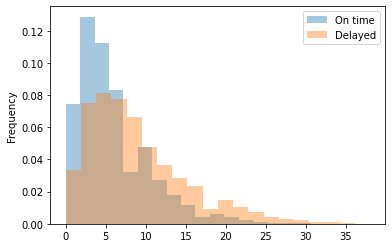

delay_last_6h


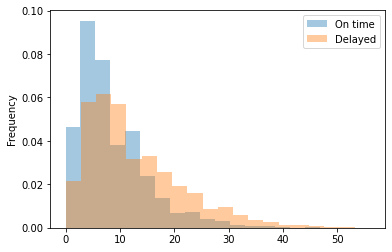

delay_last_2h


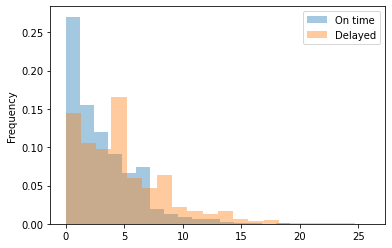

In [27]:
for var in best_feats.head(3)['features'].values:
    print(var)
    df.groupby('delay_15')[var].plot.hist(bins=20,density=True,alpha=0.4) #density=True makes the same y-axis (sum is 100%)
    plt.legend(['On time','Delayed']) # the order is False first and True after (ascending order 0>1)
    plt.show()

delay_last_4h


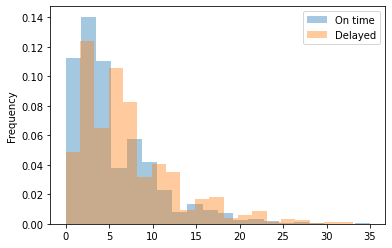

delay_last_6h


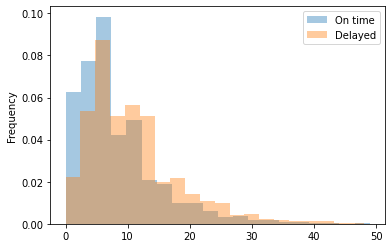

delay_last_2h


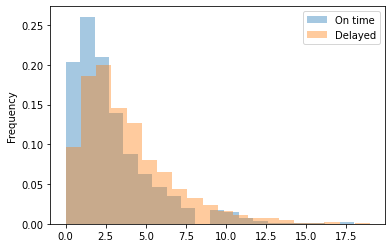

In [28]:
#past flights alone has a low correlation with the output
# if we zoom-in in the top 5 airlines with most delay, can we see the same correlation?
for var in best_feats.head(3)['features'].values:
    print(var)
    df[df['OPERA'].isin(comp_delay_5)].groupby('delay_15')[var].plot.hist(bins=20,density=True,alpha=0.4) #density=True makes the same y-axis (sum is 100%)
    plt.legend(['On time','Delayed']) # the order is False first and True after (ascending order 0>1)
    plt.show()
#the answer is yes, these  past delayed variables will not make significant changes on the model

In [29]:
features=[feat for feat in df.columns if df[feat].dtype not in ["object"] and 
          feat not in ['delay_15','min_diff','Fecha-O','is_top_5_airlines_delay_and_delay_15',
                      'is_top_10_airlines_delay_and_delay_15']]
catfeats=[feat for feat in df.columns if df[feat].dtype in ["category"] and 
          feat not in ['delay_15','min_diff','Fecha-O','is_top_5_airlines_delay_and_delay_15',
                      'is_top_10_airlines_delay_and_delay_15']]
print(catfeats)
features


['Ori-I', 'Des-I', 'Emp-I', 'Ori-O', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day']


['Ori-I',
 'Des-I',
 'Emp-I',
 'Ori-O',
 'Des-O',
 'Emp-O',
 'DIA',
 'MES',
 'AÑO',
 'DIANOM',
 'TIPOVUELO',
 'OPERA',
 'SIGLAORI',
 'SIGLADES',
 'high_season',
 'high_season_2',
 'period_day',
 'delay_previous_flight',
 'delay_last_1h',
 'qtd_flights_1h',
 'perc_delay_1h',
 'delay_last_2h',
 'qtd_flights_2h',
 'perc_delay_2h',
 'delay_last_4h',
 'qtd_flights_4h',
 'perc_delay_4h',
 'delay_last_6h',
 'qtd_flights_6h',
 'perc_delay_6h',
 'delay_last_12h',
 'qtd_flights_12h',
 'perc_delay_12h',
 'delay_last_18h',
 'qtd_flights_18h',
 'perc_delay_18h',
 'delay_last_24h',
 'qtd_flights_24h',
 'perc_delay_24h',
 'is_top_5_airlines_delay',
 'is_top_10_airlines_delay',
 'qtd_flights_is_top_5_airlines_delay_1h',
 'qtd_flights_is_top_10_airlines_delay_1h',
 'qtd_flights_is_top_5_airlines_delay_and_delay_15_1h',
 'qtd_flights_is_top_10_airlines_delay_and_delay_15_1h',
 'qtd_flights_is_top_5_airlines_delay_2h',
 'qtd_flights_is_top_10_airlines_delay_2h',
 'qtd_flights_is_top_5_airlines_delay_and_

In [30]:
#split datasets for training the model
#I am doing two experiments, one with the val df splitting by date and the other one random, using the same test dataset to evaluate the model

#test dataset (outside of the model)
test=df2[df2.index.date>=pd.to_datetime('2017-12-01')]

#X datasets
x_train=df2[df2.index.date<=pd.to_datetime('2017-10-01')][features]
x_val=df2[(df2.index.date>pd.to_datetime('2017-10-01'))&(df2.index.date<pd.to_datetime('2017-12-01'))][features]

#output variable
y_train=df2[df2.index.date<=pd.to_datetime('2017-10-01')]['delay_15']
y_val=df2[(df2.index.date>pd.to_datetime('2017-10-01'))&(df2.index.date<pd.to_datetime('2017-12-01'))]['delay_15']

from sklearn.model_selection import train_test_split
#percentage of validation dataset in the total for second experiment
perc_val=y_val.shape[0]/(y_train.shape[0]+y_val.shape[0])
#for second experiment
x_train_2,x_val_2,y_train_2,y_val_2 = train_test_split(df2[df2.index.date<pd.to_datetime('2017-12-01')][features],
                                                       df2[df2.index.date<pd.to_datetime('2017-12-01')]['delay_15'],
                                                       test_size=perc_val)
print("first experiment",x_train.shape[0],x_val.shape[0],test.shape[0])
print("second experiment",x_train_2.shape[0],x_val_2.shape[0],test.shape[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packa

first experiment 49761 11918 6357
second experiment 49761 11918 6357


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


In [31]:
#for this first model we are going with these conditions:
    # use of scale_pos_weight and keep the original data
    # validation dataset is the month of november 
    
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
sc_pos_w_value= y_train[y_train==False].shape[0]/y_train[y_train==True].shape[0]# number of negative samples / number of positive samples
print(f'neg_value {y_train[y_train==False].shape[0]} pos_values: {y_train[y_train==True].shape[0]}')
sc_pos_w_value

neg_value 41301 pos_values: 8460


4.881914893617021

In [32]:
d_train = lgb.Dataset(x_train,y_train)
d_valid = lgb.Dataset(x_val,y_val)

#LightGBM uses variables with dtype='category' as categorical columns in the model (even if they are strings)
params = {
        'objective' :'binary',
        'metric':'auc',
        'learning_rate' :0.0151459,
        'num_leaves' : 6,
        'max_depth':3,
        'feature_fraction': 0.75, 
        'bagging_fraction': 0.95, 
        'bagging_freq':4,
        'max_bin':20,
        'lambda_l1':4,
        'lambda_l2':4,
        'boosting_type' : 'gbdt',
        'verbose':-1,
        'min_data_in_leaf':20,
       'min_gain_to_split':0.03,
     'scale_pos_weight':sc_pos_w_value
    }
bst = lgb.train(params,
                d_train, 
                1000, 
               # valid_sets=[d_train], 
               # valid_names=["train"],
                valid_sets=[d_train,d_valid],
                valid_names=["train","test"],
                verbose_eval=50,
                early_stopping_rounds=50)
test["y_pred"]=bst.predict(test[features])
test["y_pred2"]=(test["y_pred"]>0.5).astype(bool)
roc_pred=roc_auc_score(test["delay_15"],test["y_pred"])
print(" AUC: ", roc_pred)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.715773	test's auc: 0.686341
[100]	train's auc: 0.721158	test's auc: 0.690617
[150]	train's auc: 0.724716	test's auc: 0.692858
[200]	train's auc: 0.72732	test's auc: 0.694878
[250]	train's auc: 0.729849	test's auc: 0.696404
[300]	train's auc: 0.732402	test's auc: 0.69749
[350]	train's auc: 0.734224	test's auc: 0.698423
[400]	train's auc: 0.736277	test's auc: 0.699202
[450]	train's auc: 0.738261	test's auc: 0.699781
[500]	train's auc: 0.740073	test's auc: 0.700088
[550]	train's auc: 0.741556	test's auc: 0.700512
[600]	train's auc: 0.743076	test's auc: 0.700668
[650]	train's auc: 0.744453	test's auc: 0.70056
Early stopping, best iteration is:
[612]	train's auc: 0.743485	test's auc: 0.700734
 AUC:  0.6958733823170326


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
#as we can see the model has a little of overfitting and the test dataset
# has a great difference for train/val AUC
#let's use the same params but with the random splitting for train/test

d_train = lgb.Dataset(x_train_2,y_train_2)
d_valid = lgb.Dataset(x_val_2,y_val_2)

#LightGBM uses variables with dtype='category' as categorical columns in the model (even if they are strings)
params = {
        'objective' :'binary',
        'metric':'auc',
        'learning_rate' :0.0151459,
        'num_leaves' : 6,
        'max_depth':3,
        'feature_fraction': 0.75, 
        'bagging_fraction': 0.95, 
        'bagging_freq':4,
        'max_bin':20,
        'lambda_l1':4,
        'lambda_l2':4,
        'boosting_type' : 'gbdt',
        'verbose':-1,
        'min_data_in_leaf':20,
       'min_gain_to_split':0.03,
     'scale_pos_weight':sc_pos_w_value
    }
bst = lgb.train(params,
                d_train, 
                1000, 
               # valid_sets=[d_train], 
               # valid_names=["train"],
                valid_sets=[d_train,d_valid],
                valid_names=["train","test"],
                verbose_eval=50,
                early_stopping_rounds=50)
test["y_pred"]=bst.predict(test[features])
test["y_pred2"]=(test["y_pred"]>0.5).astype(bool)
roc_pred=roc_auc_score(test["delay_15"],test["y_pred"])
print(" AUC: ", roc_pred)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.712069	test's auc: 0.711474
[100]	train's auc: 0.718359	test's auc: 0.716879
[150]	train's auc: 0.722025	test's auc: 0.719385
[200]	train's auc: 0.724847	test's auc: 0.721307
[250]	train's auc: 0.727152	test's auc: 0.722971
[300]	train's auc: 0.729242	test's auc: 0.724314
[350]	train's auc: 0.731386	test's auc: 0.725673
[400]	train's auc: 0.733255	test's auc: 0.726357
[450]	train's auc: 0.734972	test's auc: 0.727113
[500]	train's auc: 0.736636	test's auc: 0.728031
[550]	train's auc: 0.738227	test's auc: 0.72875
[600]	train's auc: 0.739796	test's auc: 0.729578
[650]	train's auc: 0.741025	test's auc: 0.730061
[700]	train's auc: 0.742271	test's auc: 0.730519
[750]	train's auc: 0.743723	test's auc: 0.731104
[800]	train's auc: 0.744943	test's auc: 0.731625
[850]	train's auc: 0.746137	test's auc: 0.732124
[900]	train's auc: 0.747378	test's auc: 0.73247
[950]	train's auc: 0.748513	test's auc: 0.732938
[1000]	trai

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


delay_15
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: y_pred, dtype: object

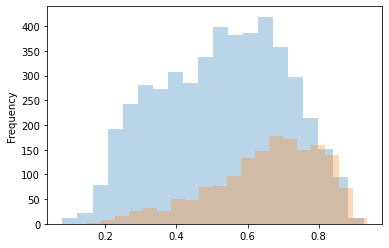

In [34]:
#we have a train/val dataset that is highly correlated but no major difference for test dataset
#let's check the distribution of the predicted result and see if 0.5 is a great cutoff
test.groupby(['delay_15'])['y_pred'].plot.hist(bins=20,stacked=True,alpha=0.3)
# yes 0.5 is a great cutoff

In [35]:
#what if for train/val dataset we take a sample of False values so we have 50/50 dataset?
# using the same params
# using the month of november for validation dataset


train=df2[df2.index.date<=pd.to_datetime('2017-10-01')]
val=df2[(df2.index.date>pd.to_datetime('2017-10-01'))&(df2.index.date<pd.to_datetime('2017-12-01'))]
train['delay_15'].value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  import sys


False    41301
True      8460
Name: delay_15, dtype: int64

In [36]:
#grouping by and using sample is a effective way to make 50/50 sample of the lowest value
train=train.groupby("delay_15").sample(train[train['delay_15']==True].shape[0])
val=val.groupby("delay_15").sample(val[val['delay_15']==True].shape[0])
x_train_3=train[features]
y_train_3=train['delay_15']
x_val_3=val[features]
y_val_3=val['delay_15']
train['delay_15'].value_counts() #to compare with the previous cell (full value)

False    8460
True     8460
Name: delay_15, dtype: int64

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.710341	test's auc: 0.67691
[100]	train's auc: 0.71805	test's auc: 0.684282
[150]	train's auc: 0.723374	test's auc: 0.689988
[200]	train's auc: 0.727081	test's auc: 0.692978
[250]	train's auc: 0.729871	test's auc: 0.694659
[300]	train's auc: 0.732492	test's auc: 0.695371
[350]	train's auc: 0.734956	test's auc: 0.696267
[400]	train's auc: 0.737111	test's auc: 0.69653
[450]	train's auc: 0.739019	test's auc: 0.69717
[500]	train's auc: 0.740961	test's auc: 0.697276
Early stopping, best iteration is:
[488]	train's auc: 0.740493	test's auc: 0.697378


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


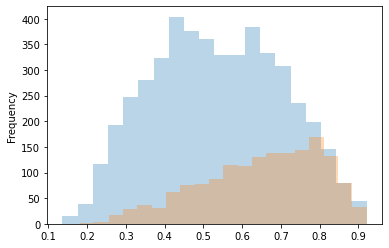

 AUC:  0.6926658292343109


In [37]:
#as we can see the model has a little of overfitting and the test dataset
# has a great difference for train/val AUC
#let's use the same params but with the random splitting for train/test
#we are removing scale_pos_weight parameter because we have a 50/50 sample (scale_pos_weight=1)

d_train = lgb.Dataset(x_train_3,y_train_3)
d_valid = lgb.Dataset(x_val_3,y_val_3)

#LightGBM uses variables with dtype='category' as categorical columns in the model (even if they are strings)
params = {
        'objective' :'binary',
        'metric':'auc',
        'learning_rate' :0.0151459,
        'num_leaves' : 6,
        'max_depth':3,
        'feature_fraction': 0.75, 
        'bagging_fraction': 0.95, 
        'bagging_freq':4,
        'max_bin':20,
        'lambda_l1':4,
        'lambda_l2':4,
        'boosting_type' : 'gbdt',
        'verbose':-1,
        'min_data_in_leaf':20,
       'min_gain_to_split':0.03
    }
bst = lgb.train(params,
                d_train, 
                1000, 
               # valid_sets=[d_train], 
               # valid_names=["train"],
                valid_sets=[d_train,d_valid],
                valid_names=["train","test"],
                verbose_eval=50,
                early_stopping_rounds=50)
test["y_pred"]=bst.predict(test[features])
test["y_pred2"]=(test["y_pred"]>0.5).astype(bool)
roc_pred=roc_auc_score(test["delay_15"],test["y_pred"])
test.groupby(['delay_15'])['y_pred'].plot.hist(bins=20,stacked=True,alpha=0.3)
plt.show()
print(" AUC: ", roc_pred)

In [38]:
#as we can see, we have similar results on the three experiments
#for convenience the next steps we are going to use our second (randomic) experiment


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.744171	test's auc: 0.729376
[400]	train's auc: 0.760235	test's auc: 0.735497
[600]	train's auc: 0.775009	test's auc: 0.738659
[800]	train's auc: 0.788239	test's auc: 0.741039
[1000]	train's auc: 0.799952	test's auc: 0.742198
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.799952	test's auc: 0.742198


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


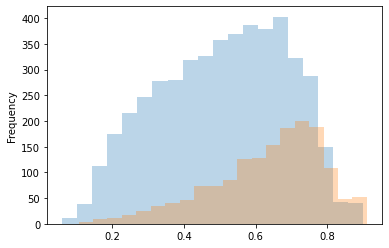

 AUC:  0.7015331018642446


In [39]:
#let's try anothers hyperparameters

#as we can see the model has a little of overfitting and the test dataset
# has a great difference for train/val AUC
#let's use the same params but with the random splitting for train/test

d_train = lgb.Dataset(x_train_2,y_train_2)
d_valid = lgb.Dataset(x_val_2,y_val_2)

#LightGBM uses variables with dtype='category' as categorical columns in the model (even if they are strings)
params = {
        'objective' :'binary',
        'metric':'auc',
        'learning_rate' :0.01151459,
        'num_leaves' : 30,
        'max_depth':5,
        'feature_fraction': 0.70, 
        'bagging_fraction': 0.80, 
        'bagging_freq':4,
        'max_bin':5,
        'lambda_l1':4,
        'lambda_l2':4,
        'boosting_type' : 'gbdt',
        'verbose':-1,
        'min_data_in_leaf':30,
       'min_gain_to_split':0.003,
     'scale_pos_weight':sc_pos_w_value
    }
bst = lgb.train(params,
                d_train, 
                1000,
                valid_sets=[d_train,d_valid],
                valid_names=["train","test"],
                verbose_eval=200,
                early_stopping_rounds=50)
test["y_pred"]=bst.predict(test[features])
test["y_pred2"]=(test["y_pred"]>0.5).astype(bool)
roc_pred=roc_auc_score(test["delay_15"],test["y_pred"])
test.groupby(['delay_15'])['y_pred'].plot.hist(bins=20,stacked=True,alpha=0.3)
plt.show()
print(" AUC: ", roc_pred)

<AxesSubplot:>

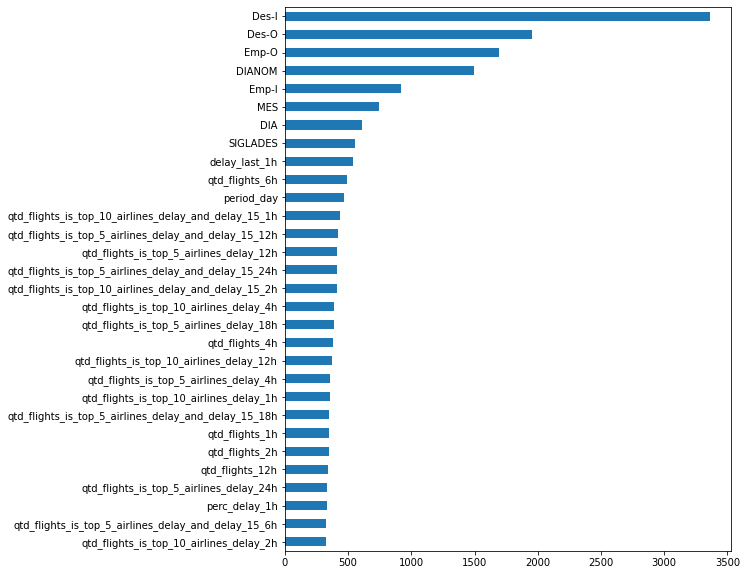

In [40]:
feat_imp = pd.Series(bst.feature_importance(), index=x_train.columns)
feat_imp.nlargest(30).sort_values(ascending=True).plot(kind='barh', figsize=(8,10))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  import sys
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futu

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.742528	test's auc: 0.718521
[400]	train's auc: 0.757233	test's auc: 0.724206
[600]	train's auc: 0.769815	test's auc: 0.726753
[800]	train's auc: 0.780601	test's auc: 0.728314
[1000]	train's auc: 0.789484	test's auc: 0.729006
[1200]	train's auc: 0.797999	test's auc: 0.730443
[1400]	train's auc: 0.806011	test's auc: 0.732313
[1600]	train's auc: 0.813478	test's auc: 0.733209
Early stopping, best iteration is:
[1636]	train's auc: 0.814616	test's auc: 0.733623


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fold: 0 auc: 0.6999542981302713


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecate

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.739628	test's auc: 0.726248
[400]	train's auc: 0.754639	test's auc: 0.731412
[600]	train's auc: 0.766961	test's auc: 0.734462
[800]	train's auc: 0.77772	test's auc: 0.736801
[1000]	train's auc: 0.787253	test's auc: 0.738349
[1200]	train's auc: 0.79554	test's auc: 0.739416
[1400]	train's auc: 0.803045	test's auc: 0.740699
[1600]	train's auc: 0.810006	test's auc: 0.741164
Early stopping, best iteration is:
[1636]	train's auc: 0.811461	test's auc: 0.741333


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fold: 1 auc: 0.6976947976908804


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in para

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.742203	test's auc: 0.720934
[400]	train's auc: 0.756859	test's auc: 0.726079
[600]	train's auc: 0.768716	test's auc: 0.729045
[800]	train's auc: 0.779437	test's auc: 0.731417
[1000]	train's auc: 0.788801	test's auc: 0.733153
[1200]	train's auc: 0.797302	test's auc: 0.734199
Early stopping, best iteration is:
[1316]	train's auc: 0.801823	test's auc: 0.734965


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is

Fold: 2 auc: 0.6999567790889136


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.739306	test's auc: 0.729432
[400]	train's auc: 0.75471	test's auc: 0.735538
[600]	train's auc: 0.767997	test's auc: 0.739396
[800]	train's auc: 0.779552	test's auc: 0.741852
Early stopping, best iteration is:
[912]	train's auc: 0.784894	test's auc: 0.742672


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fold: 3 auc: 0.7026755180306934


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecate

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.739926	test's auc: 0.731213
[400]	train's auc: 0.754269	test's auc: 0.734579
[600]	train's auc: 0.76639	test's auc: 0.737785
[800]	train's auc: 0.77712	test's auc: 0.739655
[1000]	train's auc: 0.78621	test's auc: 0.741395
[1200]	train's auc: 0.795079	test's auc: 0.742885
[1400]	train's auc: 0.803233	test's auc: 0.744104
Early stopping, best iteration is:
[1368]	train's auc: 0.801991	test's auc: 0.744279


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fold: 4 auc: 0.7011996087919952
all auc: 0.7036805674344146


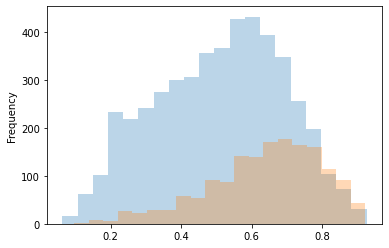

In [41]:
import gc
#Since this is not a ultra low latency model and we have small number of observations(data),
#we can use kfold to maximize the chance of finding a particular situation for delay
#KFold is a common practice nowadays, which means subdividing the dataset in n folds and create n models with every data belonging on the train dataset and test dataset at the same time
num_folds=5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
train=df2[df2.index.date<pd.to_datetime('2017-12-01')] #keeping the test dataset with december (and outside of our model)

outs=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train['delay_15'])):
    x_train, y_train = train[features].iloc[train_idx], train['delay_15'].iloc[train_idx]
    x_valid, y_valid = train[features].iloc[valid_idx], train['delay_15'].iloc[valid_idx]
    
    d_train = lgb.Dataset(x_train,y_train)
    d_valid = lgb.Dataset(x_valid,y_valid)
    params = {
            'objective' :'binary',
            'metric':'auc',
            'learning_rate' :0.02151459,
            'num_leaves' : 10,
            'max_depth':4,
            'feature_fraction': 0.90, 
            'bagging_fraction': 0.90, 
            'bagging_freq':4,
            'max_bin':40,
            'lambda_l1':4,
            'lambda_l2':4,
            'boosting_type' : 'gbdt',
            'verbose':-1,
            'min_data_in_leaf':50,
           'min_gain_to_split':0.005,
         'scale_pos_weight':sc_pos_w_value
        }
    bst = lgb.train(params,
                    d_train, 
                    2000,
                    valid_sets=[d_train,d_valid],
                    valid_names=["train","test"],
                    verbose_eval=200,
                    early_stopping_rounds=50)
    
    test[f"y_pred_kfold_{n_fold}"]=bst.predict(test[features])
    print(f'Fold: {n_fold} auc: {roc_auc_score(test["delay_15"],test[f"y_pred_kfold_{n_fold}"])}')
    outs.append(f"y_pred_kfold_{n_fold}") # so we can calculate the auc of the mean of every model
    del x_train,x_valid,y_train,y_valid,d_train,d_valid
    gc.collect()
    test['y_pred_kfold']=test[outs].mean(axis=1)
print(f'all auc: {roc_auc_score(test["delay_15"],test["y_pred_kfold"])}')
test.groupby(['delay_15'])['y_pred_kfold'].plot.hist(bins=20,stacked=True,alpha=0.3)
plt.show()


    

I apologize for this cell, I did not had time to work on these challenge this week I had personal problems, a lot going on my own job and the biggest is coding in my iPad without keyboard.

Wish I could've give you guys  more detail of everything that happened on this notebook.


things I can do that I didn't do:
* arima model (time series model could even be a feature of the delay model)
* zoom on the history of flight number (is daily,weekly.. rate of delay)
* holiday dates on chile and the destination ( is holiday/ is sunday(day of week) after/before holiday)
* apply analysis of delay time series, maybe a fourier transform could indicate a harmonic of futures delays


In [42]:
df.head()

,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,...,qtd_flights_is_top_5_airlines_delay_and_delay_15_12h,qtd_flights_is_top_10_airlines_delay_and_delay_15_12h,qtd_flights_is_top_5_airlines_delay_18h,qtd_flights_is_top_10_airlines_delay_18h,qtd_flights_is_top_5_airlines_delay_and_delay_15_18h,qtd_flights_is_top_10_airlines_delay_and_delay_15_18h,qtd_flights_is_top_5_airlines_delay_24h,qtd_flights_is_top_10_airlines_delay_24h,qtd_flights_is_top_5_airlines_delay_and_delay_15_24h,qtd_flights_is_top_10_airlines_delay_and_delay_15_24h
Fecha-I,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:15:00,11,SCEL,MMMX,AMX,2017-01-01 00:04:00,11,SCEL,MMMX,AMX,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:15:00,572,SCEL,SKBO,LAN,2017-01-01 01:10:00,572,SCEL,SKBO,LAN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:23:00,495,SCEL,MPTO,CMP,2017-01-01 01:29:00,495,SCEL,MPTO,CMP,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-01 01:33:00,240,SCEL,SKBO,AVA,2017-01-01 01:38:00,240,SCEL,SKBO,AVA,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-01-01 01:42:00,276,SCEL,MPTO,CMP,2017-01-01 01:40:00,276,SCEL,MPTO,CMP,1,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
